<a href="https://colab.research.google.com/github/Moo-ninja/SRGANAssignment5Midterm/blob/main/MatthewSanchez_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Code for Assignment 2

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from zipfile import ZipFile

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
import random

from datetime import datetime
import os
!pip install split-folders
import splitfolders

from tensorflow.python.client import device_lib

import cv2
from sklearn.utils import shuffle

from PIL import Image
import matplotlib.pyplot as plt
!pip3 install config
from config import Config
from keras.utils import np_utils

#print(device_lib.list_local_devices())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#intial code to access zip file that was uploaded to personal drive

from google.colab import drive
drive.mount('/content/drive') 
!unzip '/content/drive/MyDrive/tiny_Data.zip'

Mounted at /content/drive
Archive:  /content/drive/MyDrive/tiny_Data.zip
   creating: Data_Small/
   creating: Data_Small/test/
   creating: Data_Small/test/DME/
 extracting: Data_Small/test/DME/DME-11053-1.jpeg  
  inflating: Data_Small/test/DME/DME-119840-1.jpeg  
  inflating: Data_Small/test/DME/DME-119840-10.jpeg  
  inflating: Data_Small/test/DME/DME-119840-11.jpeg  
  inflating: Data_Small/test/DME/DME-119840-12.jpeg  
  inflating: Data_Small/test/DME/DME-119840-13.jpeg  
  inflating: Data_Small/test/DME/DME-119840-14.jpeg  
  inflating: Data_Small/test/DME/DME-119840-15.jpeg  
  inflating: Data_Small/test/DME/DME-119840-16.jpeg  
  inflating: Data_Small/test/DME/DME-119840-17.jpeg  
  inflating: Data_Small/test/DME/DME-119840-18.jpeg  
  inflating: Data_Small/test/DME/DME-119840-19.jpeg  
  inflating: Data_Small/test/DME/DME-119840-2.jpeg  
  inflating: Data_Small/test/DME/DME-119840-20.jpeg  
  inflating: Data_Small/test/DME/DME-119840-21.jpeg  
  inflating: Data_Small/test/DME

In [3]:
# Uses unzipped images and accesses them directly
test_direct_original = r'Data_Small/test'
train_direct_original = r'Data_Small/train'

splitting_folder = r'Data_Small/SplittingData'

# Splits original data into 80% for the train and 20% for the test
# Uncomment below line when needing to create folder with split data
splitfolders.ratio(train_direct_original, output = 'Data_Small/SplittingData', seed = 90, ratio = (.8,.2))

new_train_split = r'Data_Small/SplittingData/train'
new_valid_split = r'Data_Small/SplittingData/val'


class_weights = {0: 2.,
                1: 1.,
                }                
train_df = pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])
test_df = pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])
val_df = pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])

Copying files: 2534 files [00:00, 6106.94 files/s]


In [4]:
# Train File Stuff

data_path = os.path.join('Data_Small/SplittingData/train')
data_dir_list = os.listdir(data_path)
print ('the data list is: ',data_dir_list)

# Assigning labels to each subfolder within the train split-folder
num_classes = 2
labels_name={'DME':0,'DRUSEN':1}

# Here data_dir_list = ['DME', 'DRUSEN']
# Loop over every subfolder
for dataset in data_dir_list:
    # load the list of image names in each subfolder category
    img_list = os.listdir(os.path.join(data_path,dataset))
    print ('Loading the images of dataset-'+'{}\n'.format(dataset))
    label = labels_name[dataset]
    num_img_files = len(img_list)
    
    # read each file and if it is corrupted exclude it , if not include it in either train or test data frames
    for i in range(num_img_files):
        img_name = img_list[i]
        img_filename = os.path.join(data_path,dataset,img_name)
        try:
            input_img = cv2.imread(img_filename)
            img_shape=input_img.shape
            row = {'FileName': img_filename, 'Label': label, 'ClassName': dataset}
            train_df = pd.concat([train_df, pd.DataFrame(row, index=[0])], ignore_index=True)
            #train_df = train_df.append({'FileName': img_filename, 'Label': label,'ClassName': dataset},ignore_index=True)       
        except:
            print ('except')                
    
    
    
print ('completed reading all the image files and assigned labels accordingly')

the data list is:  ['DME', 'DRUSEN']
Loading the images of dataset-DME

Loading the images of dataset-DRUSEN

completed reading all the image files and assigned labels accordingly


In [5]:
# Validation File Stuff

data_path = os.path.join('Data_Small/SplittingData/val')
data_dir_list = os.listdir(data_path)
print ('the data list is: ',data_dir_list)

# Assigning labels to each subfolder within the validation split-folder
num_classes = 2
labels_name={'DME':0,'DRUSEN':1}

# Here data_dir_list = ['DME', 'DRUSEN']
# Loop over every subfolder
for dataset in data_dir_list:
    # load the list of image names in each subfolder category
    img_list = os.listdir(os.path.join(data_path,dataset))
    print ('Loading the images of dataset-'+'{}\n'.format(dataset))
    label = labels_name[dataset]
    num_img_files = len(img_list)
    
    for i in range(num_img_files):
        img_name = img_list[i]
        img_filename = os.path.join(data_path,dataset,img_name)
        try:
            input_img = cv2.imread(img_filename)
            img_shape=input_img.shape
            row = {'FileName': img_filename, 'Label': label, 'ClassName': dataset}
            val_df = pd.concat([val_df, pd.DataFrame(row, index=[0])], ignore_index=True)            
            #val_df = val_df.append({'FileName': img_filename, 'Label': label,'ClassName': dataset},ignore_index=True)       
        except:
            print ('except')                
    
    
    
print ('completed reading all the image files and assigned labels accordingly')

the data list is:  ['DME', 'DRUSEN']
Loading the images of dataset-DME

Loading the images of dataset-DRUSEN

completed reading all the image files and assigned labels accordingly


In [6]:
# Test File Stuff

data_path = os.path.join('Data_Small/test')
data_dir_list = os.listdir(data_path)
print ('the data list is: ',data_dir_list)

# Assigning labels to each subfolder within the test split-folder
num_classes = 2
labels_name={'DME':0,'DRUSEN':1}

# Here data_dir_list = ['DME', 'DRUSEN']
# Loop over every subfolder
for dataset in data_dir_list:
    # load the list of image names in each subfolder category
    img_list = os.listdir(os.path.join(data_path,dataset))
    print ('Loading the images of dataset-'+'{}\n'.format(dataset))
    label = labels_name[dataset]
    num_img_files = len(img_list)
    
    for i in range(num_img_files):
        img_name = img_list[i]
        img_filename = os.path.join(data_path,dataset,img_name)
        try:
            input_img = cv2.imread(img_filename)
            img_shape=input_img.shape
            row = {'FileName': img_filename, 'Label': label, 'ClassName': dataset}
            test_df = pd.concat([test_df, pd.DataFrame(row, index=[0])], ignore_index=True)            
            #test_df = test_df.append({'FileName': img_filename, 'Label': label,'ClassName': dataset},ignore_index=True)       
        except:
            print ('except')                
    
    
    
print ('completed reading all the image files and assigned labels accordingly')

the data list is:  ['DME', 'DRUSEN']
Loading the images of dataset-DME

Loading the images of dataset-DRUSEN

completed reading all the image files and assigned labels accordingly


In [7]:
# Code that takes the loaded images from the respective folders and places them into a csv file which can be used to 
# generate the images/data in a way for training a VGG16 model
if not os.path.exists('data_files'):
    os.mkdir('data_files')

train_df.to_csv('data_files/dataframe_train.csv')
test_df.to_csv('data_files/dataframe_test.csv')
val_df.to_csv('data_files/dataframe_val.csv')
print('The train, test, and val files have been saved as a csv')

The train, test, and val files have been saved as a csv


In [8]:
# Defining Parameters
class Config():
    def __init__(self):
        pass
    
    num_classes = 2
    labels_to_class = {0:'DME',1:'DRUSEN'}
    class_to_labels = {'DME':0,'DRUSEN':1}
    resize = 128	
    num_epochs = 20 # Used to 20 epochs to train model for a long enough time where the val_loss and loss begin to converge
                    # This also allows for the model to be trained in a way where accuracy converges to a similar number
    batch_size = 32 # Used batch size of 32 to ensure the number of samples being tested will take less memory and also help the model train faster

number of train samples:  2027
number of test samples:  514
number of val samples:  507
(128, 128, 3)
x shape:  (32, 128, 128, 3)
label shape:  (32, 2)
the label is:  [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
  

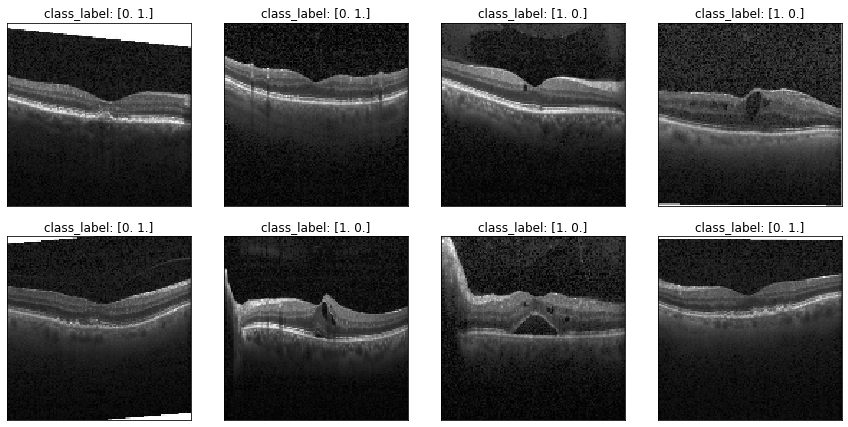

In [9]:
# Class for Generating data; includes shuffling, loading samples, and applying preprocessing
# This class is called by code later which takes the file path of the specific csv files and loads the samples, shuffles the data,
# preprocesses the data, and finally generates the images with a corresponding label
class DataGeneration(object):    

# Implements a data loader that reads the data and creates a data generator which can be directly used to train your model
    
    def __init__(self,root_dir=None):     
        self.root_dir = root_dir
        
    def load_samples(self,csv_file):
        
        """
        function to read a csv file and create a list of samples of format
        [[image1_filename,label1], [image2_filename,label2],...].
        
        Args:
            csv_file - csv file containing data information
            
        Returns:
            samples - a list of format [[image1_filename,label1], [image2_filename,label2],...]
        """
        # Reads the csv file
        data = pd.read_csv(os.path.join(self.root_dir,'data_files',csv_file))
        data = data[['FileName', 'Label', 'ClassName']]
        # Get the filename contained in the first column
        file_names = list(data.iloc[:,0])
        # Get the labels present in the second column
        labels = list(data.iloc[:,1])
        samples=[]
        for samp,lab in zip(file_names,labels):
            samples.append([samp,lab])
        return samples
        
    def shuffle_data(self,data):
        data = shuffle(data)
        return data
    
    def preprocessing(self,img,label):      
        try:
         img = cv2.resize(img,(Config.resize,Config.resize))
         img = img/255
         label = np_utils.to_categorical(label, Config.num_classes)
        except Exception as e:
          print(str(e))
                   
        return img, label
    
    def data_generator(self,data,batch_size=10,shuffle=True):              
        """
        Yields the next training batch.
        Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
        """
        num_samples = len(data)
        if shuffle:
            data = self.shuffle_data(data)
        while True:   
            for offset in range(0, num_samples, batch_size):
#                print ('startring index: ', offset) 
                # Get the samples you'll use in this batch
                batch_samples = data[offset:offset+batch_size]
                # Initialise X_train and y_train arrays for this batch
                X_train = []
                y_train = []
                # For each example
                for batch_sample in batch_samples:
#                    print (batch_sample)
                    # Load image (X)
#                    x = batch_sample[0]
                    img_name = batch_sample[0]
                    label = batch_sample[1]

                    img = cv2.imread(os.path.join(self.root_dir,img_name))
#                    print (img.shape)
#                   img = cv2.resize(img,(128,128))
                    # Preprocessing
                    img,label = self.preprocessing(img,label)
#                    print (img.shape)
                    X_train.append(img)
                    y_train.append(label)
        
                # Make sure they're numpy arrays (as opposed to lists)
                X_train = np.array(X_train)
#                X_train = np.rollaxis(X_train,1,4)
                y_train = np.array(y_train)
        
                # The generator-y part: yield the next training batch            
                yield X_train, y_train

if __name__=='__main__':
# provides file paths to respective csvs and acquires the corresponding samples needed to train model using DataGeneration class
   dataloader = DataGeneration(root_dir = r'/content/')
   
   train_data_path = 'dataframe_train.csv'
   test_data_path = 'dataframe_test.csv'
   val_data_path = 'dataframe_val.csv'

   train_samples = dataloader.load_samples(train_data_path)
   test_samples = dataloader.load_samples(test_data_path)
   val_samples = dataloader.load_samples(val_data_path)

   num_train_samples = len(train_samples)
   num_test_samples = len(test_samples)
   num_val_samples = len(val_samples)

   print('number of train samples: ', num_train_samples)
   print('number of test samples: ', num_test_samples) 
   print('number of val samples: ', num_val_samples)

   # Creates generator by calling DataGeneration Class 
   batch_size = Config.batch_size
   train_datagen = dataloader.data_generator(train_samples, batch_size=batch_size)
   test_datagen = dataloader.data_generator(test_samples, batch_size=batch_size)
   val_datagen = dataloader.data_generator(val_samples, batch_size=batch_size)
   
   input_shape = (Config.resize, Config.resize,3)
   print(input_shape)

   for k in range(1):
       x,y = next(train_datagen)
       print ('x shape: ', x.shape)
       print ('label shape: ', y.shape)
       print ('the label is: ',y)
    
   # we can plot the data and see by ourselves
   fig = plt.figure(1,figsize=(12,12))
   for i in range(8):
      plt.subplot(4,4,i+1)
      plt.tight_layout()
      #x[i] = x[i][:,:,::-1] # converting BGR to RGB
      plt.imshow(x[i][:,:,::-1], interpolation='none')
      plt.title("class_label: {}".format(y[i]))
      plt.xticks([])
      plt.yticks([])
   plt

# Builds Model using VGG16 similar to assignment 1
   image_input = Input(shape = (128, 128, 3))
   base_model = applications.vgg16.VGG16(input_tensor = image_input,
                                 include_top = False,
                                 weights = 'imagenet')

   base_output = base_model.layers[-1].output

   flat1 = Flatten()(base_output)
   fc1 = Dense(8192, activation = 'relu')(flat1)
   dropfc1 = Dropout(0.5)(fc1)
   fc2 = Dense(4096, activation = 'relu')(dropfc1)
   dropfc2 = Dropout(0.5)(fc2)

   # num of classes = 2
   output = Dense(2, activation = 'softmax')(dropfc2)

   for layer in base_model.layers[:-9]:
       layer.trainable = False

   model = Model(image_input, output)
  
   model.summary()   

In [10]:
# compiles the model
opt = Adam(lr = 0.00001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# Training the model
history = model.fit(train_datagen,
                              epochs = Config.num_epochs,#20
                              steps_per_epoch = num_train_samples // batch_size,
                              validation_data = val_datagen,
                              validation_steps = num_val_samples // batch_size,
                              class_weight = class_weights)

model.save_weights('early_stop_model.hdf5')

Epoch 1/20
63/63 [==============================] - 17s 119ms/step - loss: 0.9275 - accuracy: 0.6226 - val_loss: 0.3761 - val_accuracy: 0.8250
Epoch 2/20
63/63 [==============================] - 7s 111ms/step - loss: 0.3681 - accuracy: 0.8690 - val_loss: 0.1295 - val_accuracy: 0.9563
Epoch 3/20
63/63 [==============================] - 7s 112ms/step - loss: 0.1937 - accuracy: 0.9409 - val_loss: 0.1681 - val_accuracy: 0.9312
Epoch 4/20
63/63 [==============================] - 7s 112ms/step - loss: 0.1398 - accuracy: 0.9609 - val_loss: 0.0738 - val_accuracy: 0.9708
Epoch 5/20
63/63 [==============================] - 7s 113ms/step - loss: 0.1156 - accuracy: 0.9614 - val_loss: 0.1006 - val_accuracy: 0.9646
Epoch 6/20
63/63 [==============================] - 7s 112ms/step - loss: 0.0886 - accuracy: 0.9744 - val_loss: 0.0717 - val_accuracy: 0.9792
Epoch 7/20
63/63 [==============================] - 7s 112ms/step - loss: 0.0321 - accuracy: 0.9935 - val_loss: 0.1059 - val_accuracy: 0.9667
Epoch

In [12]:
# Test Model Functions & Confusion Matrix function

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes#[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [13]:
# Testing Model
XA2, y_trueA2 = [], []
i = 0
while i < 30:
    temp_X, temp_y_true = next(test_datagen)
    if i < 1:
        XA2 = temp_X
        y_trueA2 = temp_y_true
    else:
        XA2 = np.concatenate((XA2, temp_X), axis=0)
        y_trueA2 = np.concatenate((y_trueA2, temp_y_true), axis = 0)
    i += 1

print(np.shape(XA2))
print(np.shape(y_trueA2))

y_predA2 = model.predict(XA2)

(930, 128, 128, 3)
(930, 2)
30/30 [==============================] - 1s 15ms/step


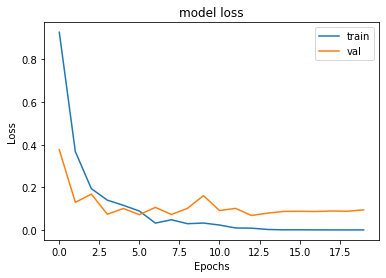

'/content/Model_Loss_Assignment2.png' -> '/content/drive/MyDrive/SRGANAssignment5/Assignment2Results/Model_Loss_Assignment2.png'


In [14]:
# Plot of Train and Validation Loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('Model_Loss_Assignment2')
plt.show()

%cp -av "/content/Model_Loss_Assignment2.png" "/content/drive/MyDrive/SRGANAssignment5/Assignment2Results"

##Confusion Matrix Assignment 2

Classification
---------------------
Normalized confusion matrix
[[0.99261993 0.00738007]
 [0.14175258 0.85824742]]
[[538   4]
 [ 55 333]]
'/content/Confusion_Matrix_Assignment2.png' -> '/content/drive/MyDrive/SRGANAssignment5/Assignment2Results/Confusion_Matrix_Assignment2.png'


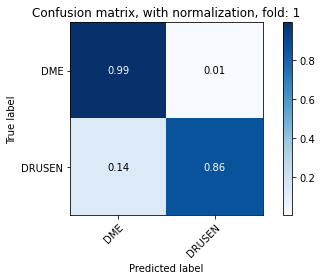

In [15]:
title_of_matrix = 'Confusion matrix, with normalization, fold: ' + str(1)
plot_name = 'Confusion_Matrix_Assignment' + str(2) + '.png'

# Prints the Confusion Matrix over test set  
print('Classification')
print('---------------------')
plot_confusion_matrix(y_trueA2.argmax(axis=1),
                      y_predA2.argmax(axis=1),
                      classes = ['DME', 'DRUSEN'],
                      normalize = True,
                      title = title_of_matrix)

plt.savefig(plot_name)
cm = confusion_matrix(y_trueA2.argmax(axis=1), y_predA2.argmax(axis=1))
print(cm)

%cp -av "/content/Confusion_Matrix_Assignment2.png" "/content/drive/MyDrive/SRGANAssignment5/Assignment2Results"

#Start of Assignment 5 Code


In [ ]:
# Calling necessary libraries for Assignment 5

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from zipfile import ZipFile

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
import random

from datetime import datetime
import os
!pip install split-folders
import splitfolders

from tensorflow.python.client import device_lib

import cv2
from sklearn.utils import shuffle
import glob
import imageio

from PIL import Image
import matplotlib.pyplot as plt
!pip3 install config
from config import Config
from keras.utils import np_utils

#print(device_lib.list_local_devices())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#intial code to access zip file that was uploaded to personal drive

from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/SRGANAssignment5/Data_Combined_Assignment5.zip'

Mounted at /content/drive
Archive:  /content/drive/MyDrive/SRGANAssignment5/Data_Combined_Assignment5.zip
  inflating: Data_Combined_Assignment5/DME-1072015-1.jpeg  
  inflating: Data_Combined_Assignment5/DME-1072015-2.jpeg  
  inflating: Data_Combined_Assignment5/DME-1072015-3.jpeg  
  inflating: Data_Combined_Assignment5/DME-1072015-4.jpeg  
  inflating: Data_Combined_Assignment5/DME-1072015-5.jpeg  
  inflating: Data_Combined_Assignment5/DME-1072015-6.jpeg  
  inflating: Data_Combined_Assignment5/DME-1072015-7.jpeg  
  inflating: Data_Combined_Assignment5/DME-1081406-1.jpeg  
  inflating: Data_Combined_Assignment5/DME-1083927-1.jpeg  
  inflating: Data_Combined_Assignment5/DME-1083927-10.jpeg  
  inflating: Data_Combined_Assignment5/DME-1083927-11.jpeg  
  inflating: Data_Combined_Assignment5/DME-1083927-12.jpeg  
  inflating: Data_Combined_Assignment5/DME-1083927-2.jpeg  
  inflating: Data_Combined_Assignment5/DME-1083927-3.jpeg  
  inflating: Data_Combined_Assignment5/DME-1083927-

### Creating 128x128 images in Personal Google Drive

In [ ]:
import zipfile
import shutil
# Function to resize images to 128x128
def resize_images_128x128(parent_folder, output_folder):

    # Define the paths to the input folders and the output folder in Google Drive
    input_folder1 = parent_folder
    output_folder_path = os.path.join('/content/drive/MyDrive', output_folder)

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    # Loop through the images in the folder and resize them to 128x128
    for filename in os.listdir(input_folder1):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            with Image.open(os.path.join(input_folder1, filename)) as img:
                img = img.resize((128, 128), resample=Image.BICUBIC)
                output_filename = os.path.join(output_folder_path, filename)
                img.save(output_filename)                                    

In [ ]:
# Paths and calling function for 128x128 images
parent_folder = '/content/Data_Combined_Assignment5'
output_path_128x128 = '/content/drive/MyDrive/SRGANAssignment5/TinyImages128x128'
output_folder_128x128 = 'SRGANAssignment5/TinyImages128x128'
#direct_output_folder_128x128 = '/content/folder128x128'

resize_images_128x128(parent_folder, output_folder_128x128)

In [ ]:
# Checks num of images within folder
def count_images_in_folder(folder_path):
    # Define the path to the folder in Google Drive
    folder_path = os.path.join('/content/drive/MyDrive', folder_path)

    # Loop through the files in the folder and count the number of images
    num_images = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            num_images += 1

    # Print the number of images in the folder
    print("Number of images in the folder:", num_images)

folder_path_128 = 'SRGANAssignment5/TinyImages128x128'
count_images_in_folder(folder_path_128)
#3048

Number of images in the folder: 3048


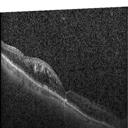

Example of Scaled 128x128 Image. File Name: DME-462675-63.jpeg


In [ ]:
# Showing Example Image of 128x128 scaled image
import random
from PIL import Image

path128Images = '/content/drive/MyDrive/SRGANAssignment5/TinyImages128x128'
file128Images = os.listdir(path128Images)
randomImage = random.choice(file128Images)

image128Random = Image.open(path128Images + '/' + randomImage)  # displayed the image
image128Random.show()

print("Example of Scaled 128x128 Image. File Name: " + randomImage)

### Creating 32x32 images in Personal Google Drive

In [ ]:
import zipfile
import shutil
# Function to resize images to 32x32
def resize_images_32x32(parent_folder, output_folder):

    # Define the paths to the input folders and the output folder in Google Drive
    input_folder32 = parent_folder
    output_folder_path = os.path.join('/content/drive/MyDrive', output_folder)

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    # Loop through the images in the folder and resize them to 32x32
    for filename in os.listdir(input_folder32):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            with Image.open(os.path.join(input_folder32, filename)) as img:
                img = img.resize((32, 32), resample=Image.BICUBIC)
                output_filename = os.path.join(output_folder_path, filename)
                img.save(output_filename)                                    

In [ ]:
# Paths and calling function for 32x32 images
parent_folder = '/content/Data_Combined_Assignment5'
output_path_32x32 = '/content/drive/MyDrive/SRGANAssignment5/TinyImages32x32'
output_folder_32x32 = 'SRGANAssignment5/TinyImages32x32'
#direct_output_folder_32x32 = '/content/folder32x32'

resize_images_32x32(parent_folder, output_folder_32x32)

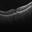

Example of Scaled 32x32 Image. File Name: DRUSEN-1193659-5.jpeg


In [ ]:
# Showing Example Image of 128x128 scaled image
import random
from PIL import Image

path32Images = '/content/drive/MyDrive/SRGANAssignment5/TinyImages32x32'
file32Images = os.listdir(path32Images)
random32Image = random.choice(file32Images)

image32Random = Image.open(path32Images + '/' + random32Image)  # displayed the image
image32Random.show()

print("Example of Scaled 32x32 Image. File Name: " + random32Image)

In [ ]:
# Checks num of images within 32x32 folder
def count_images_in_folder(folder_path):
    # Define the path to the folder in Google Drive
    folder_path = os.path.join('/content/drive/MyDrive', folder_path)
    #folder_path = folder_path

    # Loop through the files in the folder and count the number of images
    num_images = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpeg") or filename.endswith(".png") or filename.endswith(".jpg"):
            num_images += 1

    # Print the number of images in the folder
    print("Number of images in the folder:", num_images)

folder_path_32 = 'SRGANAssignment5/TinyImages32x32'
count_images_in_folder(folder_path_32)
#20042 IT IS NOT GETTING ALL OF IMAGES FOR SOME REASON

Number of images in the folder: 3048


### Transfering the Data for the folders


In [ ]:
# Copies data from TinyImages128x128 to Google Colab local directory
# I create a local folder called TinyImages128Local to store data
%cp -av "/content/drive/MyDrive/SRGANAssignment5/TinyImages128x128" "/content/TinyImages128Local"

In [ ]:
# Copies data from TinyImages128x128 to Google Colab local directory
# I create a local folder called TinyImages128Local to store data
%cp -av "/content/drive/MyDrive/SRGANAssignment5/TinyImages32x32" "/content/TinyImages32Local"

'/content/drive/MyDrive/SRGANAssignment5/TinyImages32x32' -> '/content/TinyImages32Local/TinyImages32x32'
'/content/drive/MyDrive/SRGANAssignment5/TinyImages32x32/DME-30521-226.jpeg' -> '/content/TinyImages32Local/TinyImages32x32/DME-30521-226.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/TinyImages32x32/DME-462675-34.jpeg' -> '/content/TinyImages32Local/TinyImages32x32/DME-462675-34.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/TinyImages32x32/DRUSEN-224974-39.jpeg' -> '/content/TinyImages32Local/TinyImages32x32/DRUSEN-224974-39.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/TinyImages32x32/DME-670450-11.jpeg' -> '/content/TinyImages32Local/TinyImages32x32/DME-670450-11.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/TinyImages32x32/DRUSEN-224974-24.jpeg' -> '/content/TinyImages32Local/TinyImages32x32/DRUSEN-224974-24.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/TinyImages32x32/DME-1591159-54.jpeg' -> '/content/TinyImages32Local/TinyImages32x32/DME-1591159-54.jpeg'
'/content/drive/

### Defining Model/Generator/Discriminator

In [ ]:
from keras.models import Sequential
from keras import layers, Model

from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

import sys,os

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

#Enables output to be printed
def blockPrint():
  sys.stdout = open(os.devnull, 'w')    

#Enables output to be printed
def enablePrint():
  sys.stdout = sys.__stdout__  

###VGG Model


In [ ]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [ ]:
lr_list_32 = sorted(os.listdir("/content/TinyImages32Local/TinyImages32x32"))

images_32_lr = []
for img in lr_list_32:
    img_lr = cv2.imread(os.path.join("/content/TinyImages32Local/TinyImages32x32", img))
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    images_32_lr.append(img_lr)   

hr_list_128 = sorted(os.listdir("/content/TinyImages128Local/TinyImages128x128"))
   
images_128_hr = []
for img in hr_list_128:
    img_hr = cv2.imread(os.path.join("/content/TinyImages128Local/TinyImages128x128", img))
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    images_128_hr.append(img_hr)   

images_lowres32 = np.array(images_32_lr)
images_highres128 = np.array(images_128_hr) 

print(images_lowres32.shape)

images_lowres32 = images_lowres32 / 255
images_highres128 = images_highres128 / 255

print(lr_list_32)
print(len(images_lowres32))
print(hr_list_128)
print(len(images_highres128))

(3048, 32, 32, 3)
['DME-1072015-1.jpeg', 'DME-1072015-2.jpeg', 'DME-1072015-3.jpeg', 'DME-1072015-4.jpeg', 'DME-1072015-5.jpeg', 'DME-1072015-6.jpeg', 'DME-1072015-7.jpeg', 'DME-1081406-1.jpeg', 'DME-1083927-1.jpeg', 'DME-1083927-10.jpeg', 'DME-1083927-11.jpeg', 'DME-1083927-12.jpeg', 'DME-1083927-2.jpeg', 'DME-1083927-3.jpeg', 'DME-1083927-4.jpeg', 'DME-1083927-5.jpeg', 'DME-1083927-6.jpeg', 'DME-1083927-7.jpeg', 'DME-1083927-8.jpeg', 'DME-1083927-9.jpeg', 'DME-1102486-1.jpeg', 'DME-1102486-2.jpeg', 'DME-1102486-3.jpeg', 'DME-1102486-4.jpeg', 'DME-11053-1.jpeg', 'DME-1141111-1.jpeg', 'DME-1141111-2.jpeg', 'DME-1141111-3.jpeg', 'DME-1141111-4.jpeg', 'DME-1141111-5.jpeg', 'DME-1163718-1.jpeg', 'DME-1163718-2.jpeg', 'DME-1163718-3.jpeg', 'DME-1163718-4.jpeg', 'DME-1163718-5.jpeg', 'DME-1163718-6.jpeg', 'DME-1163718-7.jpeg', 'DME-1163718-8.jpeg', 'DME-1163718-9.jpeg', 'DME-1169820-1.jpeg', 'DME-1169820-2.jpeg', 'DME-1169820-3.jpeg', 'DME-1169820-4.jpeg', 'DME-119840-1.jpeg', 'DME-119840-1

Example of 32x32 image


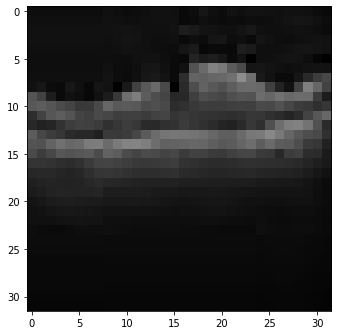

In [ ]:
#Example image of size 32x32
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(images_lowres32[2], (32, 32, 3)))
#plt.imshow(np.reshape(images_lowres32[2], (32, 32, 1)))
print("Example of 32x32 image")

Example of same image but as 128x128


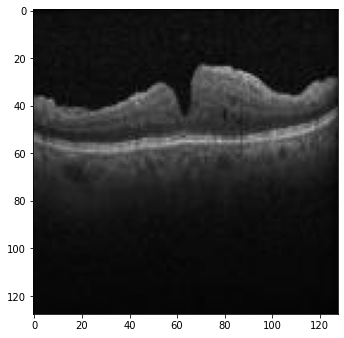

In [ ]:
#Same Example image but 128x128 version
plt.figure(figsize=(12, 6))
plt.subplot(122)
plt.imshow(np.reshape(images_highres128[2], (128, 128, 3)))
print("Example of same image but as 128x128")

##Splitting Data into Low & High Res Train/Test


In [ ]:
# Spliting data
lowres_train, lowres_test, highres_train, hr_test = train_test_split(images_lowres32, images_highres128, 
                                                      test_size=0.30, random_state=65)

In [ ]:
hr_shape = (highres_train.shape[1], highres_train.shape[2], highres_train.shape[3])
lr_shape = (lowres_train.shape[1], lowres_train.shape[2], lowres_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

# Generator Summary
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [ ]:
#Discriminator Summary
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [ ]:
# Buidling VGG model
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

80134624/80134624 [==============================] - 5s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                            

In [ ]:
# Gan model
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [ ]:
batch_size = 4 #lets make it 4 instead of 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(highres_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(highres_train[start_idx:end_idx])
    train_lr_batches.append(lowres_train[start_idx:end_idx])

##Training

In [ ]:
epochs = 120
#Enumerate training over epochs
for e in range(epochs):
    
    blockPrint()
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    enablePrint()

    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

100%|██████████| 533/533 [01:27<00:00,  6.07it/s]


# Copying Specific Models back and forth


In [ ]:
generator.save("gen_e_"+ "120" +".h5")

In [ ]:
# Copying Model to Google Drive
%cp -av "/content/gen_e_90.h5" "/content/drive/MyDrive/SRGANAssignment5/Models"

In [ ]:
# Copying Google Drive Model to Google Colab
%cp -av "/content/drive/MyDrive/SRGANAssignment5/Models/gen_e_120.h5" "/content"

'/content/drive/MyDrive/SRGANAssignment5/Models/gen_e_120.h5' -> '/content/gen_e_120.h5'


In [ ]:
# Copying Generator Loss Values to txt file an storing it in Google Drive
with open('GeneratorLossValues.txt', 'w') as f:
    for item in g_losses:
        f.write(str(item) + '\n')

%cp -av "/content/GeneratorLossValues.txt" "/content/drive/MyDrive/SRGANAssignment5/Gen_Loss_Values"

In [ ]:
# Copying Google Drive Generator Loss to Google Colab
%cp -av "/content/drive/MyDrive/SRGANAssignment5/Gen_Loss_Values/GeneratorLossValues.txt" "/content"

'/content/drive/MyDrive/SRGANAssignment5/Gen_Loss_Values/GeneratorLossValues.txt' -> '/content/GeneratorLossValues.txt'


In [ ]:
# Open the text file for reading
with open('GeneratorLossValues.txt', 'r') as file:
    # Read the contents of the file into a list of strings
    linesgen = file.readlines()

# Convert the list of strings to a list of values
g_losses = []
for line in linesgen:
    g_losses.append(float(line.strip()))  # Assumes the file contains floating-point values, adjust as needed
print(g_losses)

[6.308367729187012, 4.9441046714782715, 3.4489099979400635, 4.340822219848633, 5.40219783782959, 4.346264839172363, 4.114380359649658, 4.12342643737793, 4.244880199432373, 4.414708614349365, 4.566022872924805, 5.252584457397461, 3.8118176460266113, 4.801324367523193, 4.144863128662109, 5.02068567276001, 3.888782262802124, 4.0042548179626465, 4.613677501678467, 4.2111005783081055, 5.679462909698486, 4.433253288269043, 3.855844736099243, 4.380214214324951, 4.81998872756958, 3.585629463195801, 5.0765886306762695, 3.58544921875, 4.495082378387451, 4.777276992797852, 5.191225051879883, 3.502596378326416, 5.767892837524414, 4.7643818855285645, 4.482324600219727, 4.536675453186035, 4.222850799560547, 3.91192626953125, 4.9817328453063965, 4.1626763343811035, 3.6690268516540527, 4.78480863571167, 4.309607982635498, 6.224932670593262, 4.2205705642700195, 4.486733913421631, 4.613205909729004, 4.374389171600342, 4.489651679992676, 4.627355575561523, 4.100250244140625, 5.66575813293457, 4.503228187

In [ ]:
# Copying Generator Loss Values to txt file an storing it in Google Drive
with open('DiscriminatorLossValues.txt', 'w') as f:
    for item in d_losses:
        f.write(str(item) + '\n')

%cp -av "/content/DiscriminatorLossValues.txt" "/content/drive/MyDrive/SRGANAssignment5/Disc_Loss_Values"

In [ ]:
# Copying Google Drive Discriminator Loss to Google Colab
%cp -av "/content/drive/MyDrive/SRGANAssignment5/Disc_Loss_Values/DiscriminatorLossValues.txt" "/content"

'/content/drive/MyDrive/SRGANAssignment5/Disc_Loss_Values/DiscriminatorLossValues.txt' -> '/content/DiscriminatorLossValues.txt'


In [ ]:
# Open the text file for reading
with open('DiscriminatorLossValues.txt', 'r') as file:
    # Read the contents of the file into a list of strings
    linesdisc = file.readlines()

# Convert the list of strings to a list of values
d_losses = []
for line in linesdisc:
    line = line.strip().replace('[','').replace(']','')  # Remove square brackets
    values = line.split('.')  # Split the string by the dot separator
    d_losses.append(str(f"{values[0]}.{values[1]}"))  # Convert to float and append to list
print(d_losses)

#Testing Model on 1 Image

1/1 [==============================] - 8s 8s/step


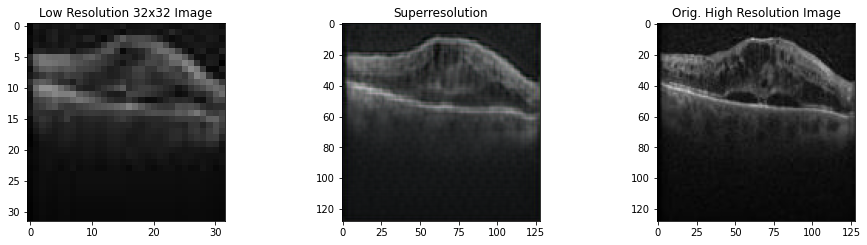

In [ ]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_120.h5', compile=False) #Using model that ran for 120 epochs


[X1, X2] = [lowres_test, hr_test] # Variables from Split Data
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Low Resolution 32x32 Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. High Resolution Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

# Testing Model on Entire Test Folder

###Generating Plots of SuperResolution image and saving to local folder

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


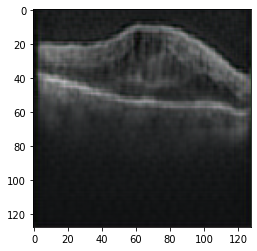

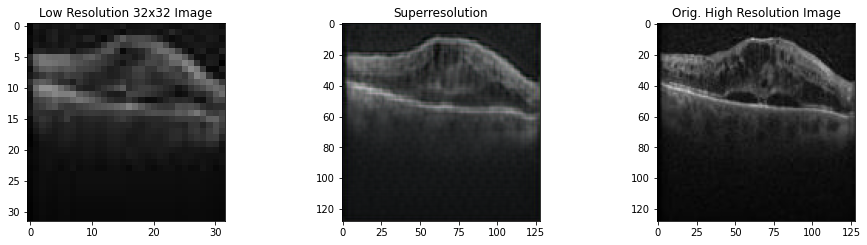

In [ ]:
import matplotlib.pyplot as plt

numTrack = 0
index = 0
for src_image, tar_image in zip(X1, X2):
  # select random example
  src_image, tar_image = X1[index], X2[index]

  gen_image = generator.predict(src_image)
  numTrackString = str(numTrack)
  # save the generated image to a local folder
  plt.imshow(gen_image[0,:,:,:])
  plt.savefig('/content/Generated_Images/gen_image' + numTrackString + '.jpg')
  numTrack = numTrack + 1 
  index = index + 1 


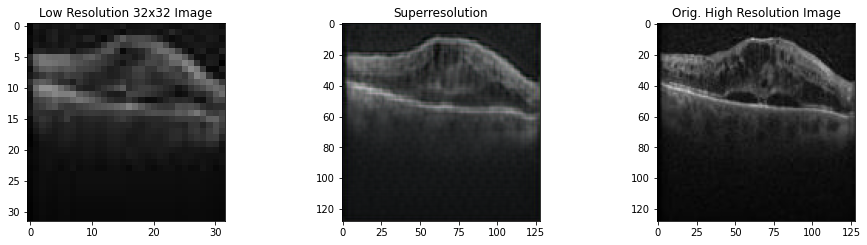

In [ ]:
# plot all three images to showcase SuperResolution works for entire folder

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Low Resolution 32x32 Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. High Resolution Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [ ]:
# Transfering SuperResolution Images to Google Folder
%cp -av "/content/Generated_Images" "/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesPlots"

'/content/Generated_Images' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesPlots/Generated_Images'
'/content/Generated_Images/gen_image0.jpg' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesPlots/Generated_Images/gen_image0.jpg'
'/content/Generated_Images/gen_image1.jpg' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesPlots/Generated_Images/gen_image1.jpg'
'/content/Generated_Images/gen_image2.jpg' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesPlots/Generated_Images/gen_image2.jpg'
'/content/Generated_Images/gen_image3.jpg' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesPlots/Generated_Images/gen_image3.jpg'
'/content/Generated_Images/gen_image4.jpg' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesPlots/Generated_Images/gen_image4.jpg'
'/content/Generated_Images/gen_image5.jpg' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesPlots/Generated_Images/gen_image5.jpg'
'/content/Generated_Images/gen_image6.jpg' 

### Generating just SuperResolution images and Saving them to folder as a JPEG


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


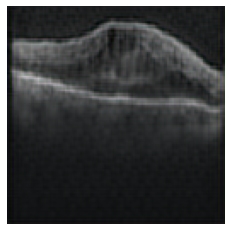

In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model
from numpy.random import randint

[X1, X2] = [lowres_test, hr_test] # Variables from Split Data

numTrack = 0
for src_image, tar_image in zip(X1, X2):
  # select random example
  src_image, tar_image = X1[ix], X2[ix]

  gen_image = generator.predict(src_image)
  numTrackString = str(numTrack)
  # save the generated image to a local folder
  plt.imshow(gen_image[0,:,:,:])
  plt.axis('off')
  plt.savefig('/content/ONLY_Generated_Images/gen_image' + numTrackString + '.jpeg', bbox_inches='tight', pad_inches=0)
  numTrack = numTrack + 1 

In [ ]:
# Transfering SuperResolution Images to Google Folder
%cp -av "/content/ONLY_Generated_Images" "/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset"

'/content/ONLY_Generated_Images' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images'
'/content/ONLY_Generated_Images/gen_image805.jpeg' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image805.jpeg'
'/content/ONLY_Generated_Images/gen_image0.jpeg' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image0.jpeg'
'/content/ONLY_Generated_Images/gen_image1.jpeg' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image1.jpeg'
'/content/ONLY_Generated_Images/gen_image2.jpeg' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image2.jpeg'
'/content/ONLY_Generated_Images/gen_image3.jpeg' -> '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image3.jpeg'
'/content/ONLY_Generated_Images/gen_image4.jpeg' -> '/content/drive/MyDrive/SRGANAssignment5/Gener

In [ ]:
# Copying Google Drive Generated Images to Google Colab
%cp -av "/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images" "/content/ONLY_Generated_Images"

'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images' -> '/content/ONLY_Generated_Images/ONLY_Generated_Images'
'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image805.jpeg' -> '/content/ONLY_Generated_Images/ONLY_Generated_Images/gen_image805.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image0.jpeg' -> '/content/ONLY_Generated_Images/ONLY_Generated_Images/gen_image0.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image1.jpeg' -> '/content/ONLY_Generated_Images/ONLY_Generated_Images/gen_image1.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image2.jpeg' -> '/content/ONLY_Generated_Images/ONLY_Generated_Images/gen_image2.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image3.jpeg' -> '/content/ONLY_Generated_Images/ONLY_

In [ ]:
# Copying Google Drive Generated Dataset to Local Google Colab Driectory
%cp -av "/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images" "/content/ParentFolderGeneratedImages"

'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image805.jpeg' -> '/content/ParentFolderGeneratedImages/ONLY_Generated_Images/gen_image805.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image0.jpeg' -> '/content/ParentFolderGeneratedImages/ONLY_Generated_Images/gen_image0.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image1.jpeg' -> '/content/ParentFolderGeneratedImages/ONLY_Generated_Images/gen_image1.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image2.jpeg' -> '/content/ParentFolderGeneratedImages/ONLY_Generated_Images/gen_image2.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images/gen_image3.jpeg' -> '/content/ParentFolderGeneratedImages/ONLY_Generated_Images/gen_image3.jpeg'
'/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Im

#Inputting SuperResolution Images to Assignment 2 Code

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 50,
    fill_mode = 'constant',

    ) 

test_generatorA5 = datagen.flow_from_directory(
    directory = '/content/ParentFolderGeneratedImages',
    #directory = '/content/drive/MyDrive/SRGANAssignment5/GeneratedImagesDataset/ONLY_Generated_Images', || Use if importing data from Google Drive
    target_size = (128, 128),
    class_mode = "categorical",
    color_mode = 'rgb',
    batch_size = 4,
    shuffle = True,
    seed = 42
    )

XA5, y_trueA5 = [], []
i = 0
while i < 30:
    temp_X, temp_y_true = test_generatorA5.next()
    if i < 1:
        XA5 = temp_X
        y_trueA5 = temp_y_true
    else:
        XA5 = np.concatenate((XA5, temp_X), axis=0)
        y_trueA5 = np.concatenate((y_trueA5, temp_y_true), axis = 0)
    i += 1

print(np.shape(XA5))
print(np.shape(y_trueA5))

y_predA5 = model.predict(XA5)

Found 915 images belonging to 1 classes.
(120, 128, 128, 3)
(120, 1)
4/4 [==============================] - 0s 8ms/step


In [ ]:
#Test Model Functions

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes#[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Classification
---------------------
Normalized confusion matrix
[[1.]]
[[120]]
'/content/Confusion_Matrix_Assignment5.png' -> '/content/drive/MyDrive/SRGANAssignment5/Assignment5Results/Confusion_Matrix_Assignment5.png'


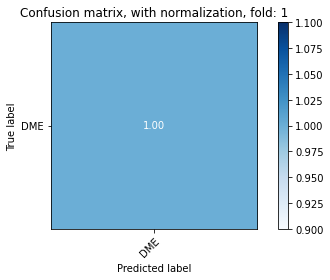

In [ ]:
title_of_matrix = 'Confusion matrix, with normalization, fold: ' + str(1)
plot_name = 'Confusion_Matrix_Assignment' + str(5) + '.png'

# Prints the Confusion Matrix over test set  
print('Classification')
print('---------------------')
plot_confusion_matrix(y_trueA5.argmax(axis=1),
                      y_predA5.argmax(axis=1),
                      classes = ['DME'],
                      normalize = True,
                      title = title_of_matrix)

plt.savefig(plot_name)
cm = confusion_matrix(y_trueA5.argmax(axis=1), y_predA5.argmax(axis=1))
print(cm)

%cp -av "/content/Confusion_Matrix_Assignment5.png" "/content/drive/MyDrive/SRGANAssignment5/Assignment5Results"

###Plotting Generator Loss from SRGAN

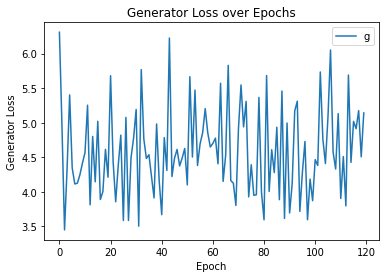

'/content/generator_loss_SRGAN.png' -> '/content/drive/MyDrive/SRGANAssignment5/Assignment5Results/generator_loss_SRGAN.png'


In [ ]:
import matplotlib.pyplot as plt
# Calculate average generator loss for each epoch
#g_losses_epoch = [np.mean(g_losses[i:i+len(train_hr_batches)]) for i in range(0, len(g_losses), len(train_hr_batches))]

# Calculate generator loss for each epoch
#g_losses_epoch = []
#for i in range(0, len(g_losses), len(train_hr_batches)):
#    epoch_losses = g_losses[i:i+len(train_hr_batches)]
#    epoch_loss = np.mean(epoch_losses)
#    g_losses_epoch.append(epoch_loss)
epochs = 120
new_g_lossses = g_losses[:epochs]
# Plot generator loss over epochs
plt.plot(new_g_lossses)
#plt.plot(generator.history[])
plt.title('Generator Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.legend('genloss')
plt.savefig('generator_loss_SRGAN.png')
plt.show()

%cp -av "/content/generator_loss_SRGAN.png" "/content/drive/MyDrive/SRGANAssignment5/Assignment5Results"